# Desafío Kaggle

## 1. Cargar datos

In [1]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c inf-398-competencia-taller-2
!unzip inf-398-competencia-taller-2.zip
!rm inf-398-competencia-taller-2.zip

Saving kaggle.json to kaggle.json
  0% 0.00/151k [00:00<?, ?B/s]
100% 151k/151k [00:00<00:00, 61.6MB/s]
Archive:  inf-398-competencia-taller-2.zip
  inflating: Examples_submission.csv  
  inflating: house_price_test.csv    
  inflating: house_price_train.csv   


In [2]:
import pandas as pd

train_df = pd.read_csv("house_price_train.csv")
test_df = pd.read_csv("house_price_test.csv")

In [3]:
train_df.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country,price
0,1898,2014-06-04 00:00:00,4.0,2.50,2770,45514,2.0,0,0,4,2770,0,1989,0,18630 NE 202nd St,Woodinville,WA 98077,USA,685000.0
1,1370,2014-05-27 00:00:00,4.0,3.00,3720,29043,2.0,0,0,3,3720,0,1991,0,10161 134th Pl NE,Kirkland,WA 98033,USA,857000.0
2,3038,2014-06-23 00:00:00,4.0,2.50,2810,11120,2.0,0,0,3,2810,0,1982,0,22120 NE 26th Pl,Sammamish,WA 98074,USA,675000.0
3,2361,2014-06-12 00:00:00,4.0,3.75,4030,10800,2.0,0,0,3,4030,0,2006,0,619 9th Ave,Kirkland,WA 98033,USA,1485000.0
4,156,2014-05-06 00:00:00,3.0,2.00,2000,7000,2.0,0,0,3,2000,0,1916,1986,6422 Marshall Ave SW,Seattle,WA 98136,USA,561000.0


## 2. EDA y Feature Engineering

In [4]:
# El ID no es necesario para el entrenamiento

train_df = train_df.drop("id", axis=1)
test_ids = test_df["id"]
test_df = test_df.drop("id", axis=1)

In [5]:
# De forma preliminar, se separa la fecha en año, mes y día

train_df['date'] = pd.to_datetime(train_df['date'])
train_df['year'] = train_df['date'].dt.year
train_df['month'] = train_df['date'].dt.month
train_df['day'] = train_df['date'].dt.day
train_df = train_df.drop('date', axis=1)

test_df['date'] = pd.to_datetime(test_df['date'])
test_df['year'] = test_df['date'].dt.year
test_df['month'] = test_df['date'].dt.month
test_df['day'] = test_df['date'].dt.day
test_df = test_df.drop('date', axis=1)

train_df.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country,price,year,month,day
0,4.0,2.50,2770,45514,2.0,0,0,4,2770,0,1989,0,18630 NE 202nd St,Woodinville,WA 98077,USA,685000.0,2014,6,4
1,4.0,3.00,3720,29043,2.0,0,0,3,3720,0,1991,0,10161 134th Pl NE,Kirkland,WA 98033,USA,857000.0,2014,5,27
2,4.0,2.50,2810,11120,2.0,0,0,3,2810,0,1982,0,22120 NE 26th Pl,Sammamish,WA 98074,USA,675000.0,2014,6,23
3,4.0,3.75,4030,10800,2.0,0,0,3,4030,0,2006,0,619 9th Ave,Kirkland,WA 98033,USA,1485000.0,2014,6,12
4,3.0,2.00,2000,7000,2.0,0,0,3,2000,0,1916,1986,6422 Marshall Ave SW,Seattle,WA 98136,USA,561000.0,2014,5,6


### 2.1. Explorar price

In [6]:
print("Cantidad de valores vacíos en el precio: ", (train_df['price'] == 0).sum())
print("Cantidad de valores totales: ", len(train_df))

# Se extraerán los valores nulos porque pueden alterar el entrenamiento

train_df = train_df.loc[~((train_df['price'] == 0))]

print("Cantidad de valores vacíos en el precio: ", (train_df['price'] == 0).sum())
print("Cantidad de valores totales: ", len(train_df))

Cantidad de valores vacíos en el precio:  40
Cantidad de valores totales:  3680
Cantidad de valores vacíos en el precio:  0
Cantidad de valores totales:  3640


<ipython-input-7-b33dbbea8b5d>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df['price'] , fit=norm);



 mu = 550835.61 and sigma = 374632.13



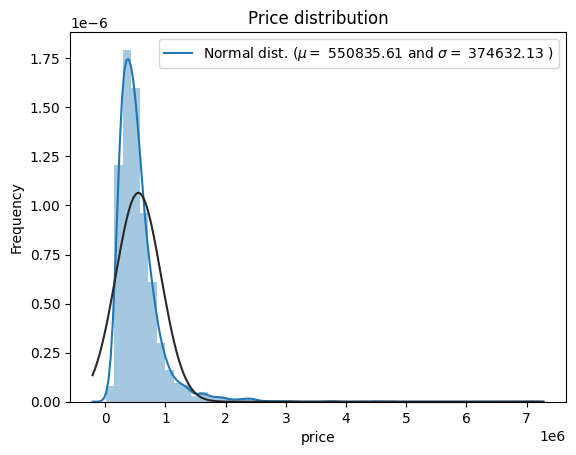

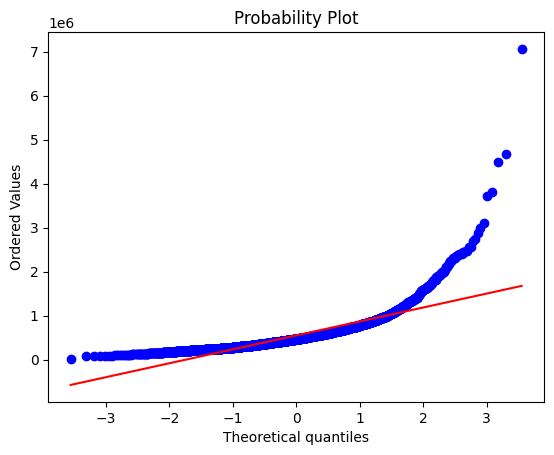

In [7]:
# https://www.kaggle.com/code/serigne/stacked-regressions-top-4-on-leaderboard/notebook

from scipy.stats import norm, skew
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.distplot(train_df['price'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train_df['price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Price distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train_df['price'], plot=plt)
plt.show()

<ipython-input-8-f80316bb337e>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df['price'] , fit=norm);



 mu = 13.06 and sigma = 0.54



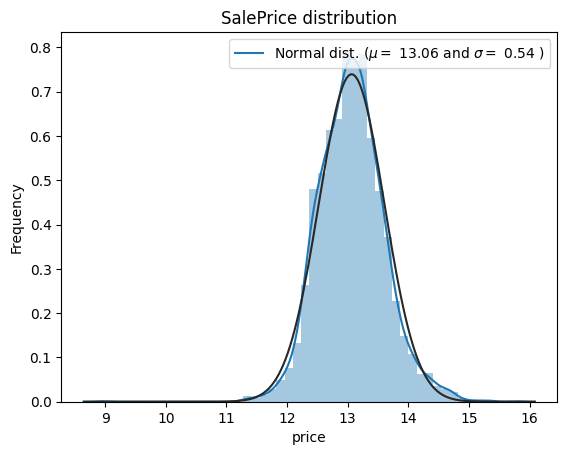

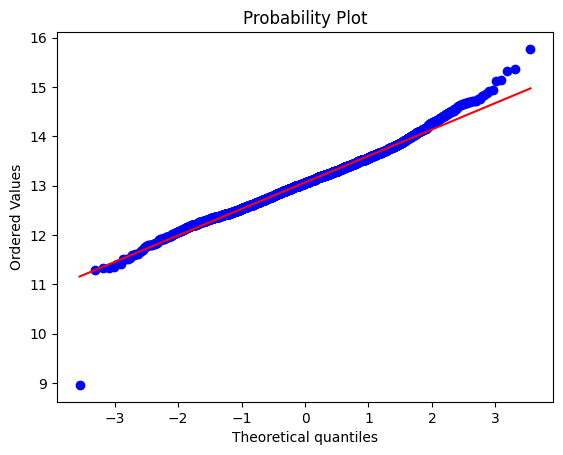

In [8]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train_df['price'] = np.log1p(train_df['price'])

#Check the new distribution
sns.distplot(train_df['price'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train_df['price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train_df['price'], plot=plt)
plt.show()

### 2.2. Explorar watefront, view, sqft_basemant y yr_renovated

In [9]:
# No hay datos nulos, aunque por el head puedo ver que waterfront, view, sqft_basement, yr_renovated pueden tener varios valores nulos

train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3640 entries, 0 to 3679
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       3640 non-null   float64
 1   bathrooms      3640 non-null   float64
 2   sqft_living    3640 non-null   int64  
 3   sqft_lot       3640 non-null   int64  
 4   floors         3640 non-null   float64
 5   waterfront     3640 non-null   int64  
 6   view           3640 non-null   int64  
 7   condition      3640 non-null   int64  
 8   sqft_above     3640 non-null   int64  
 9   sqft_basement  3640 non-null   int64  
 10  yr_built       3640 non-null   int64  
 11  yr_renovated   3640 non-null   int64  
 12  street         3640 non-null   object 
 13  city           3640 non-null   object 
 14  statezip       3640 non-null   object 
 15  country        3640 non-null   object 
 16  price          3640 non-null   float64
 17  year           3640 non-null   int32  
 18  month        

<Axes: ylabel='count'>

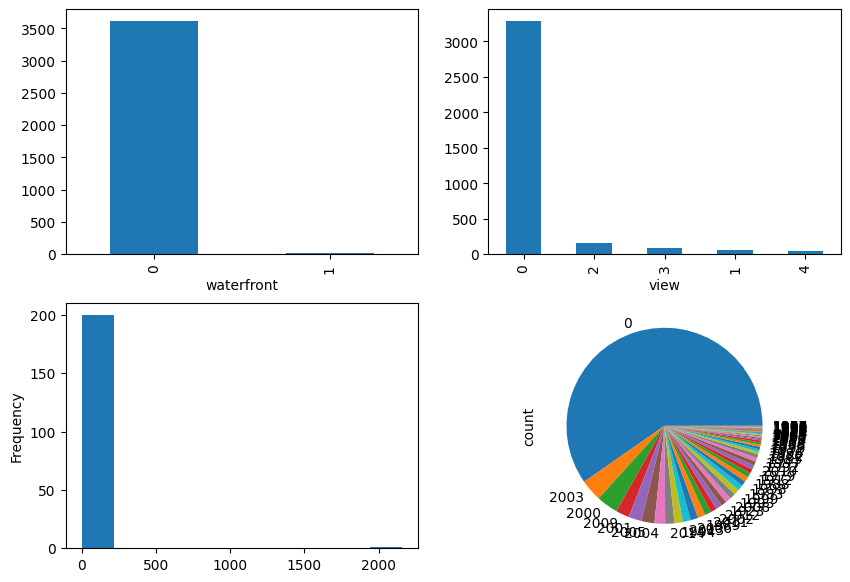

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,7))

plt.subplot(2, 2, 1)
train_df['waterfront'].value_counts().plot(kind='bar')

plt.subplot(2, 2, 2)
train_df['view'].value_counts().plot(kind='bar')

plt.subplot(2, 2, 3)
train_df['sqft_basement'].value_counts().plot(kind='hist')

plt.subplot(2, 2, 4)
train_df['yr_renovated'].value_counts().plot(kind='pie')

In [11]:
# Ahora hay que ver si hay alguna correlación entre la cantidad la existencia de estos datos minoritarios y el precio

print(f"Precio con waterfront: {train_df.loc[train_df['waterfront'] == 1]['price'].mean()}")
print(f"Precio sin waterfront: {train_df.loc[train_df['waterfront'] == 0]['price'].mean()}")

# Evidentemente hay un aumento, entonces es importante mantener esta feature

Precio con waterfront: 14.021233172762301
Precio sin waterfront: 13.057823806247136


In [12]:
# Ahora para view también parece ser relevante

for i in range(5):
  print(f"Precio con view {i}: {train_df.loc[train_df['view'] == i]['price'].mean()}")

Precio con view 0: 13.006441349798257
Precio con view 1: 13.587243241428597
Precio con view 2: 13.472814941194866
Precio con view 3: 13.657724215809893
Precio con view 4: 13.943499608945322


In [13]:
# La existencia de sótano permite aumentar el valor de la propiedad

print(f"Precio sin basement: {train_df.loc[train_df['sqft_basement'] == 0]['price'].mean()}")
print(f"Precio con basement: {train_df.loc[train_df['sqft_basement'] > 0]['price'].mean()}")

Precio sin basement: 12.973046109063464
Precio con basement: 13.197372509543197


In [14]:
# En este caso no parece ser muy relevante el uso de la columna de remodelación, ya que en promedio todos los precios son similares.

print(f"Precio sin remodelación: {train_df.loc[train_df['yr_renovated'] == 0]['price'].mean()}")
print(f"Precio con remodelación: {train_df.loc[train_df['yr_renovated'] > 0]['price'].mean()}")

train_df = train_df.drop('yr_renovated', axis=1)
test_df = test_df.drop('yr_renovated', axis=1)

Precio sin remodelación: 13.091151795848319
Precio con remodelación: 13.024874598857567


In [15]:
train_df.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,street,city,statezip,country,price,year,month,day
0,4.0,2.50,2770,45514,2.0,0,0,4,2770,0,1989,18630 NE 202nd St,Woodinville,WA 98077,USA,13.437176,2014,6,4
1,4.0,3.00,3720,29043,2.0,0,0,3,3720,0,1991,10161 134th Pl NE,Kirkland,WA 98033,USA,13.661194,2014,5,27
2,4.0,2.50,2810,11120,2.0,0,0,3,2810,0,1982,22120 NE 26th Pl,Sammamish,WA 98074,USA,13.422469,2014,6,23
3,4.0,3.75,4030,10800,2.0,0,0,3,4030,0,2006,619 9th Ave,Kirkland,WA 98033,USA,14.210926,2014,6,12
4,3.0,2.00,2000,7000,2.0,0,0,3,2000,0,1916,6422 Marshall Ave SW,Seattle,WA 98136,USA,13.237478,2014,5,6


### 2.3. Transformar month y day a formato sinusoidal

In [16]:
import numpy as np

# Código obtenido de tarea 1 de Introducción a deep learning y redes neuronales

def sinecosine_column(df, column, period):
    df['sin_'+column] = np.sin(2 * np.pi * df[column] / period)
    df['cos_'+column] = np.cos(2 * np.pi * df[column] / period)
    df.drop([column], axis=1, inplace=True)
    return df

sinecosine_column(train_df,"month",12)
sinecosine_column(train_df,"day",30)

sinecosine_column(test_df,"month",12)
sinecosine_column(test_df,"day",30)

train_df.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,...,street,city,statezip,country,price,year,sin_month,cos_month,sin_day,cos_day
0,4.0,2.50,2770,45514,2.0,0,0,4,2770,0,...,18630 NE 202nd St,Woodinville,WA 98077,USA,13.437176,2014,1.224647e-16,-1.000000,0.743145,0.669131
1,4.0,3.00,3720,29043,2.0,0,0,3,3720,0,...,10161 134th Pl NE,Kirkland,WA 98033,USA,13.661194,2014,5.000000e-01,-0.866025,-0.587785,0.809017
2,4.0,2.50,2810,11120,2.0,0,0,3,2810,0,...,22120 NE 26th Pl,Sammamish,WA 98074,USA,13.422469,2014,1.224647e-16,-1.000000,-0.994522,0.104528
3,4.0,3.75,4030,10800,2.0,0,0,3,4030,0,...,619 9th Ave,Kirkland,WA 98033,USA,14.210926,2014,1.224647e-16,-1.000000,0.587785,-0.809017
4,3.0,2.00,2000,7000,2.0,0,0,3,2000,0,...,6422 Marshall Ave SW,Seattle,WA 98136,USA,13.237478,2014,5.000000e-01,-0.866025,0.951057,0.309017


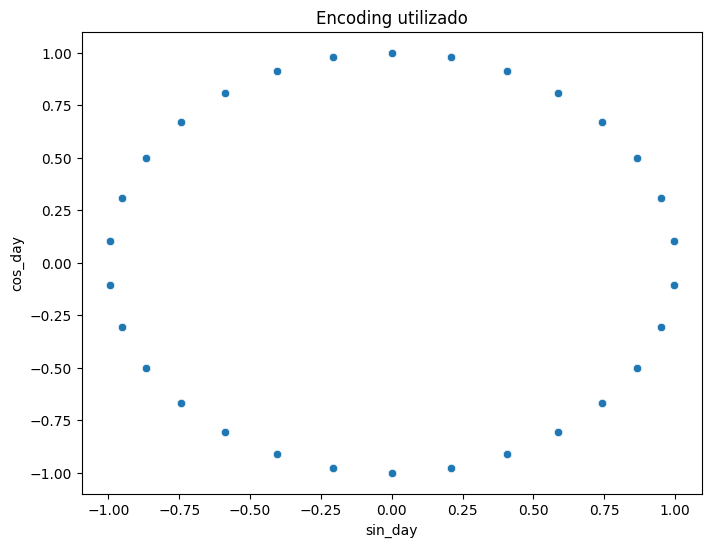

In [17]:
import seaborn as sns

fig = plt.figure(figsize=(8, 6))

sns.scatterplot(data=train_df, x="sin_day", y="cos_day").set_title("Encoding utilizado")

plt.show()

### 2.4. Separar ZIP code

In [18]:
# El ZIP code debería ser suficiente para determinar el valor de una propiedad en base a su terreno
# Por ello vamos a prescindir de la columna street

train_df = train_df.drop('street', axis=1)
test_df = test_df.drop('street', axis=1)

train_df.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,city,statezip,country,price,year,sin_month,cos_month,sin_day,cos_day
0,4.0,2.50,2770,45514,2.0,0,0,4,2770,0,1989,Woodinville,WA 98077,USA,13.437176,2014,1.224647e-16,-1.000000,0.743145,0.669131
1,4.0,3.00,3720,29043,2.0,0,0,3,3720,0,1991,Kirkland,WA 98033,USA,13.661194,2014,5.000000e-01,-0.866025,-0.587785,0.809017
2,4.0,2.50,2810,11120,2.0,0,0,3,2810,0,1982,Sammamish,WA 98074,USA,13.422469,2014,1.224647e-16,-1.000000,-0.994522,0.104528
3,4.0,3.75,4030,10800,2.0,0,0,3,4030,0,2006,Kirkland,WA 98033,USA,14.210926,2014,1.224647e-16,-1.000000,0.587785,-0.809017
4,3.0,2.00,2000,7000,2.0,0,0,3,2000,0,1916,Seattle,WA 98136,USA,13.237478,2014,5.000000e-01,-0.866025,0.951057,0.309017


In [19]:
# El código postal tiene formato "AA 12345", donde los primeros dos valores son el estado,
# el primer número es una zona grande, el segundo y el tercero es de una zona de correos y los últimos dos son de oficinas locales
# https://www.businessinsider.com/what-do-zip-codes-mean-2015-6

print(train_df['statezip'][1000])

train_df[['state', 'number_code']] = train_df['statezip'].str.split(' ', expand=True)

train_df["broad_area"] = [str(z)[0:1] for z in train_df['number_code']]
train_df["central_post_office"] = [str(z)[1:3] for z in train_df['number_code']]
train_df["small_post_office"] = [str(z)[3:] for z in train_df['number_code']]

train_df = train_df.drop('number_code', axis=1)
train_df = train_df.drop('statezip', axis=1)

test_df[['state', 'number_code']] = test_df['statezip'].str.split(' ', expand=True)

test_df["broad_area"] = [str(z)[0:1] for z in test_df['number_code']]
test_df["central_post_office"] = [str(z)[1:3] for z in test_df['number_code']]
test_df["small_post_office"] = [str(z)[3:] for z in test_df['number_code']]

train_df['central_post_office'] = train_df['central_post_office'].astype(int)
test_df['central_post_office'] = test_df['central_post_office'].astype(int)

train_df['small_post_office'] = train_df['small_post_office'].astype(int)
test_df['small_post_office'] = test_df['small_post_office'].astype(int)

test_df = test_df.drop('number_code', axis=1)
test_df = test_df.drop('statezip', axis=1)

WA 98058


In [20]:
# El estado solo tiene un valor, así que no aporta a la regresión del precio

print(train_df['state'].value_counts())
train_df = train_df.drop('state', axis=1)
test_df = test_df.drop('state', axis=1)

state
WA    3640
Name: count, dtype: int64


In [21]:
pd.set_option('display.max_columns', None)
train_df.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,city,country,price,year,sin_month,cos_month,sin_day,cos_day,broad_area,central_post_office,small_post_office
0,4.0,2.50,2770,45514,2.0,0,0,4,2770,0,1989,Woodinville,USA,13.437176,2014,1.224647e-16,-1.000000,0.743145,0.669131,9,80,77
1,4.0,3.00,3720,29043,2.0,0,0,3,3720,0,1991,Kirkland,USA,13.661194,2014,5.000000e-01,-0.866025,-0.587785,0.809017,9,80,33
2,4.0,2.50,2810,11120,2.0,0,0,3,2810,0,1982,Sammamish,USA,13.422469,2014,1.224647e-16,-1.000000,-0.994522,0.104528,9,80,74
3,4.0,3.75,4030,10800,2.0,0,0,3,4030,0,2006,Kirkland,USA,14.210926,2014,1.224647e-16,-1.000000,0.587785,-0.809017,9,80,33
4,3.0,2.00,2000,7000,2.0,0,0,3,2000,0,1916,Seattle,USA,13.237478,2014,5.000000e-01,-0.866025,0.951057,0.309017,9,81,36


### 2.5. Explorar city y country

In [22]:
# Dentro del país solo está USA, no aporta valor

print(train_df['country'].value_counts())
train_df = train_df.drop('country', axis=1)
test_df = test_df.drop('country', axis=1)

country
USA    3640
Name: count, dtype: int64


In [23]:
# Existe un gran número de ciudades, por lo cual aplicaremos one-hot encoding al final con get_dummies()
# https://www.geeksforgeeks.org/ml-label-encoding-of-datasets-in-python/

In [24]:
train_df

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,city,price,year,sin_month,cos_month,sin_day,cos_day,broad_area,central_post_office,small_post_office
0,4.0,2.50,2770,45514,2.0,0,0,4,2770,0,1989,Woodinville,13.437176,2014,1.224647e-16,-1.000000,0.743145,0.669131,9,80,77
1,4.0,3.00,3720,29043,2.0,0,0,3,3720,0,1991,Kirkland,13.661194,2014,5.000000e-01,-0.866025,-0.587785,0.809017,9,80,33
2,4.0,2.50,2810,11120,2.0,0,0,3,2810,0,1982,Sammamish,13.422469,2014,1.224647e-16,-1.000000,-0.994522,0.104528,9,80,74
3,4.0,3.75,4030,10800,2.0,0,0,3,4030,0,2006,Kirkland,14.210926,2014,1.224647e-16,-1.000000,0.587785,-0.809017,9,80,33
4,3.0,2.00,2000,7000,2.0,0,0,3,2000,0,1916,Seattle,13.237478,2014,5.000000e-01,-0.866025,0.951057,0.309017,9,81,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3675,3.0,1.00,1180,5002,1.5,0,0,3,1180,0,1946,Shoreline,12.551469,2014,5.000000e-01,-0.866025,-0.406737,0.913545,9,81,55
3676,4.0,2.00,2520,6000,1.0,0,0,3,1400,1120,1921,Seattle,13.681980,2014,5.000000e-01,-0.866025,0.866025,-0.500000,9,81,3
3677,3.0,1.00,1150,8145,1.0,0,0,4,990,160,1932,Shoreline,12.577640,2014,1.224647e-16,-1.000000,-0.994522,0.104528,9,81,55
3678,2.0,1.00,910,2002,1.5,0,0,3,910,0,1900,Seattle,13.304687,2014,-5.000000e-01,-0.866025,0.207912,0.978148,9,81,12


### 2.6. Explorar condition, floors, yr_built, sqft_above, sqft_living, sqft_lot, bedrooms, bathrooms

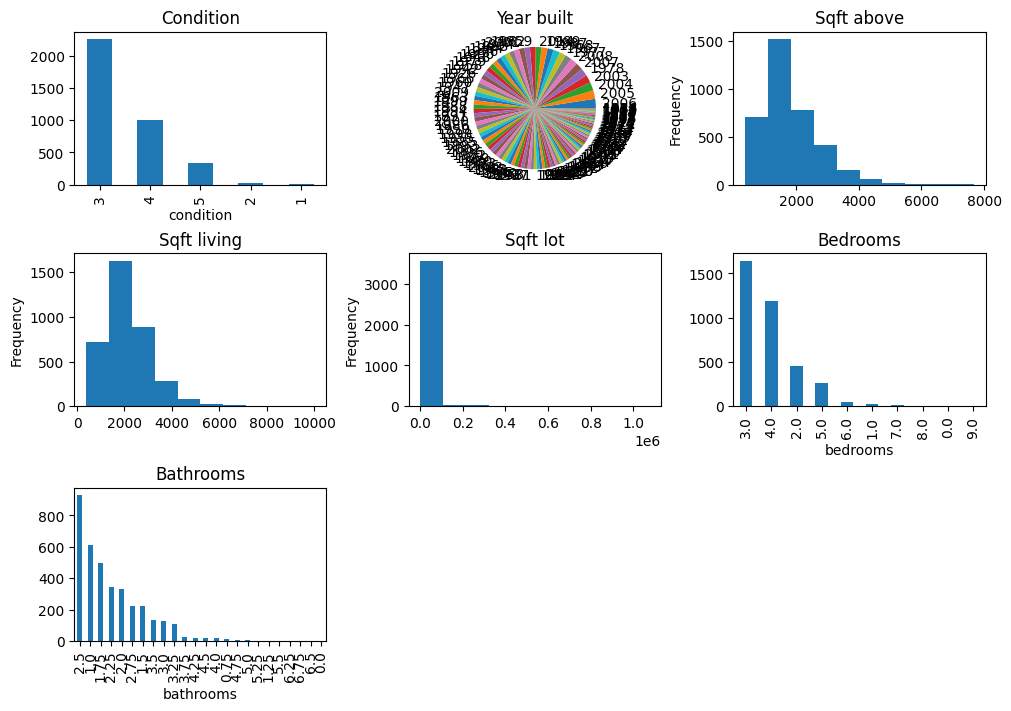

In [25]:
fig = plt.figure(figsize=(10,7), constrained_layout=True)

plt.subplot(3, 3, 1)
train_df['condition'].value_counts().plot(kind='bar')
plt.title("Condition")

plt.subplot(3, 3, 2)
train_df['yr_built'].value_counts().plot(kind='pie')
plt.title("Year built")

plt.subplot(3, 3, 3)
train_df['sqft_above'].plot(kind='hist')
plt.title("Sqft above")

plt.subplot(3, 3, 4)
train_df['sqft_living'].plot(kind='hist')
plt.title("Sqft living")

plt.subplot(3, 3, 5)
train_df['sqft_lot'].plot(kind='hist')
plt.title("Sqft lot")

plt.subplot(3, 3, 6)
train_df['bedrooms'].value_counts().plot(kind='bar')
plt.title("Bedrooms")

plt.subplot(3, 3, 7)
train_df['bathrooms'].value_counts().plot(kind='bar')
plt.title("Bathrooms")

plt.show()

In [26]:
# Veamos atributo por atributo si podemos hacer algo
# Para la condición parece que aumenta mientras más alta sea su condición

for i in range(1, 6):
  print(f"Precio con condition {i}: {train_df.loc[train_df['condition'] == i]['price'].mean()}")

Precio con condition 1: 12.063844927965764
Precio con condition 2: 12.424333321615729
Precio con condition 3: 13.074758900134547
Precio con condition 4: 13.003510206467102
Precio con condition 5: 13.23994978185965


In [27]:
# Veamos si no hay ningún año 0

print("Cantidad de year_built 0: ", len(train_df.loc[(train_df['yr_built'] == 0)]))

# Perfecto

Cantidad de year_built 0:  0


In [28]:
# Ahora analizaremos para los sqft

rangos_sqft_above = [0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]
rangos_sqft_living = [0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000]
rangos_sqft_lot = [0, 50000, 100000, 150000, 200000]

print("-"*50)
print("Precios para sqft above")

for i in range(len(rangos_sqft_above)- 1):
  print(f"Precio con rango {rangos_sqft_above[i]} a {rangos_sqft_above[i+1]}: \
  {train_df.loc[(train_df['sqft_above'] < rangos_sqft_above[i+1]) & (rangos_sqft_above[i] < train_df['sqft_above'])]['price'].mean()}")

print("-"*50)
print("Precios para sqft living")

for i in range(len(rangos_sqft_living)- 1):
  print(f"Precio con rango {rangos_sqft_living[i]} a {rangos_sqft_living[i+1]}: \
  {train_df.loc[(train_df['sqft_living'] < rangos_sqft_living[i+1]) & (rangos_sqft_living[i] < train_df['sqft_living'])]['price'].mean()}")

print("-"*50)
print("Precios para sqft lot")

for i in range(len(rangos_sqft_lot)- 1):
  print(f"Precio con rango {rangos_sqft_lot[i]} a {rangos_sqft_lot[i+1]}: \
  {train_df.loc[(train_df['sqft_lot'] < rangos_sqft_lot[i+1]) & (rangos_sqft_lot[i] < train_df['sqft_lot'])]['price'].mean()}")

# Todo parece ir en orden

--------------------------------------------------
Precios para sqft above
Precio con rango 0 a 500:   12.036342248083262
Precio con rango 500 a 1000:   12.654118062480263
Precio con rango 1000 a 1500:   12.854081392011919
Precio con rango 1500 a 2000:   13.065370233534024
Precio con rango 2000 a 2500:   13.22696217313519
Precio con rango 2500 a 3000:   13.374075250250124
Precio con rango 3000 a 3500:   13.587785946692314
Precio con rango 3500 a 4000:   13.799598409387949
--------------------------------------------------
Precios para sqft living
Precio con rango 0 a 500:   12.036342248083262
Precio con rango 500 a 1000:   12.507172332826373
Precio con rango 1000 a 1500:   12.722777445318005
Precio con rango 1500 a 2000:   12.903967401578566
Precio con rango 2000 a 2500:   13.131746220924057
Precio con rango 2500 a 3000:   13.313508231933616
Precio con rango 3000 a 3500:   13.536053094053745
Precio con rango 3500 a 4000:   13.712780112784616
Precio con rango 4000 a 4500:   13.884115530

In [29]:
# Para bathroom y bedroom no se ve nada anomálo, así que se salta su revisión.

### 2.8. Transformar datos numéricos que son categóricos

In [30]:
# Algunos categóricos que son numéricos serían condition, view, waterfront

train_df['condition'] = train_df['condition'].apply(str)
train_df['view'] = train_df['view'].apply(str)
train_df['waterfront'] = train_df['waterfront'].apply(str)

test_df['condition'] = test_df['condition'].apply(str)
test_df['view'] = test_df['view'].apply(str)
test_df['waterfront'] = test_df['waterfront'].apply(str)

from sklearn.preprocessing import LabelEncoder

cols = ('condition', 'view', 'waterfront')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder()
    lbl.fit(list(train_df[c].values))
    train_df[c] = lbl.transform(list(train_df[c].values))

    lbl = LabelEncoder()
    lbl.fit(list(test_df[c].values))
    test_df[c] = lbl.transform(list(test_df[c].values))

# shape
print('Shape: {}'.format(train_df.shape))

Shape: (3640, 21)


In [31]:
train_df

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,city,price,year,sin_month,cos_month,sin_day,cos_day,broad_area,central_post_office,small_post_office
0,4.0,2.50,2770,45514,2.0,0,0,3,2770,0,1989,Woodinville,13.437176,2014,1.224647e-16,-1.000000,0.743145,0.669131,9,80,77
1,4.0,3.00,3720,29043,2.0,0,0,2,3720,0,1991,Kirkland,13.661194,2014,5.000000e-01,-0.866025,-0.587785,0.809017,9,80,33
2,4.0,2.50,2810,11120,2.0,0,0,2,2810,0,1982,Sammamish,13.422469,2014,1.224647e-16,-1.000000,-0.994522,0.104528,9,80,74
3,4.0,3.75,4030,10800,2.0,0,0,2,4030,0,2006,Kirkland,14.210926,2014,1.224647e-16,-1.000000,0.587785,-0.809017,9,80,33
4,3.0,2.00,2000,7000,2.0,0,0,2,2000,0,1916,Seattle,13.237478,2014,5.000000e-01,-0.866025,0.951057,0.309017,9,81,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3675,3.0,1.00,1180,5002,1.5,0,0,2,1180,0,1946,Shoreline,12.551469,2014,5.000000e-01,-0.866025,-0.406737,0.913545,9,81,55
3676,4.0,2.00,2520,6000,1.0,0,0,2,1400,1120,1921,Seattle,13.681980,2014,5.000000e-01,-0.866025,0.866025,-0.500000,9,81,3
3677,3.0,1.00,1150,8145,1.0,0,0,3,990,160,1932,Shoreline,12.577640,2014,1.224647e-16,-1.000000,-0.994522,0.104528,9,81,55
3678,2.0,1.00,910,2002,1.5,0,0,2,910,0,1900,Seattle,13.304687,2014,-5.000000e-01,-0.866025,0.207912,0.978148,9,81,12


In [32]:
# Que broad_area y year tengan valor 0 indica que solo existe un valor, entonces estas columnas no aportan valor a la predicción

train_df = train_df.drop('year', axis=1)
train_df = train_df.drop('broad_area', axis=1)

test_df = test_df.drop('year', axis=1)
test_df = test_df.drop('broad_area', axis=1)

### 2.9. Revisar skewness

In [33]:
numeric_feats = test_df.dtypes[test_df.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = test_df[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
waterfront,12.261317
sqft_lot,6.597885
view,3.200410
sqft_living,2.607540
sqft_above,1.843168
sqft_basement,1.823587
condition,1.017612
bathrooms,0.904439
floors,0.552023
small_post_office,0.545205


In [34]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    train_df[feat] = boxcox1p(train_df[feat], lam)
    test_df[feat] = boxcox1p(test_df[feat], lam)

There are 17 skewed numerical features to Box Cox transform


In [35]:
train_df['price'].head()

0    13.437176
1    13.661194
2    13.422469
3    14.210926
4    13.237478
Name: price, dtype: float64

### 2.10. Aplicar get_dummies para generar one-hot encoding

In [36]:
train_df = pd.get_dummies(train_df)
test_df = pd.get_dummies(test_df)

train_df['city_Inglewood-Finn Hill'] = False

test_df['city_Beaux Arts Village'] = False
test_df['city_Milton'] = False
test_df['city_Preston'] = False
test_df['city_Skykomish'] = False
test_df['city_Snoqualmie Pass'] = False

print(train_df.shape, test_df.shape)

(3640, 62) (920, 61)


### 2.11. Reordenar columnas

In [37]:
train_df = train_df.reindex(sorted(train_df.columns), axis=1)
test_df = test_df.reindex(sorted(test_df.columns), axis=1)

## 3. Entrenamiento

### 3.1. Separar en testeo y validación

In [38]:
# Así, el dataset para entrenar final quedó como

train_df.head()

# Ahora toca entrenar varios modelos para revisar qué tal va

,bathrooms,bedrooms,central_post_office,city_Algona,city_Auburn,city_Beaux Arts Village,city_Bellevue,city_Black Diamond,city_Bothell,city_Burien,city_Carnation,city_Clyde Hill,city_Covington,city_Des Moines,city_Duvall,city_Enumclaw,city_Fall City,city_Federal Way,city_Inglewood-Finn Hill,city_Issaquah,city_Kenmore,city_Kent,city_Kirkland,city_Lake Forest Park,city_Maple Valley,city_Medina,city_Mercer Island,city_Milton,city_Newcastle,city_Normandy Park,city_North Bend,city_Pacific,city_Preston,city_Ravensdale,city_Redmond,city_Renton,city_Sammamish,city_SeaTac,city_Seattle,city_Shoreline,city_Skykomish,city_Snoqualmie,city_Snoqualmie Pass,city_Tukwila,city_Vashon,city_Woodinville,city_Yarrow Point,condition,cos_day,cos_month,floors,price,sin_day,sin_month,small_post_office,sqft_above,sqft_basement,sqft_living,sqft_lot,view,waterfront,yr_built
0,1.378202,1.820334,6.221214,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,1.540963,0.532501,-6.666667,1.194318,13.437176,0.579507,1.224647e-16,6.148461,15.226280,0.0,15.226280,26.647728,0.0,0.0,14.165608
1,1.540963,1.820334,6.221214,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1.194318,0.619937,-1.735359,1.194318,13.661194,-0.829834,4.180491e-01,4.647709,16.216056,0.0,16.216056,24.476818,0.0,0.0,14.168748
2,1.378202,1.820334,6.221214,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,1.194318,0.100164,-6.666667,1.194318,13.422469,-3.613832,1.224647e-16,6.073289,15.273396,0.0,15.273396,20.300189,0.0,0.0,14.154600
3,1.755286,1.820334,6.221214,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1.194318,-1.466013,-6.666667,1.194318,14.210926,0.478749,1.224647e-16,4.647709,16.492379,0.0,16.492379,20.182347,0.0,0.0,14.192207
4,1.194318,1.540963,6.244956,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,1.194318,0.274789,-1.735359,1.194318,13.237478,0.703023,4.180491e-01,4.792130,14.182841,0.0,14.182841,18.491718,0.0,0.0,14.049150


In [39]:
test_df.head()

,bathrooms,bedrooms,central_post_office,city_Algona,city_Auburn,city_Beaux Arts Village,city_Bellevue,city_Black Diamond,city_Bothell,city_Burien,city_Carnation,city_Clyde Hill,city_Covington,city_Des Moines,city_Duvall,city_Enumclaw,city_Fall City,city_Federal Way,city_Inglewood-Finn Hill,city_Issaquah,city_Kenmore,city_Kent,city_Kirkland,city_Lake Forest Park,city_Maple Valley,city_Medina,city_Mercer Island,city_Milton,city_Newcastle,city_Normandy Park,city_North Bend,city_Pacific,city_Preston,city_Ravensdale,city_Redmond,city_Renton,city_Sammamish,city_SeaTac,city_Seattle,city_Shoreline,city_Skykomish,city_Snoqualmie,city_Snoqualmie Pass,city_Tukwila,city_Vashon,city_Woodinville,city_Yarrow Point,condition,cos_day,cos_month,floors,sin_day,sin_month,small_post_office,sqft_above,sqft_basement,sqft_living,sqft_lot,view,waterfront,yr_built
0,1.378202,1.540963,6.244956,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,1.194318,0.730463,-6.666667,1.194318,-1.133108e-15,1.224647e-16,3.618223,12.597323,8.864879,13.222028,13.521379,0.000000,0.0,14.193765
1,1.289269,2.055642,6.244956,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,1.540963,-0.109496,-1.735359,0.730463,-3.613832e+00,4.180491e-01,6.404587,12.878993,11.147538,14.182841,18.952267,0.000000,0.0,14.160895
2,1.615941,1.540963,6.244956,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,1.540963,-2.909732,-6.666667,1.540963,-2.290549e-01,1.224647e-16,2.750250,14.813810,10.272202,15.422686,17.552807,1.540963,0.0,14.148295
3,1.378202,1.540963,6.221214,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,1.820334,0.532501,-1.735359,0.730463,5.795074e-01,4.180491e-01,5.622899,13.439773,10.868631,14.482913,18.676490,0.000000,0.0,14.164038
4,1.378202,1.540963,6.221214,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1.194318,0.532501,-6.666667,0.730463,5.795074e-01,1.224647e-16,4.071754,12.125370,11.222867,13.716698,19.350177,0.000000,0.0,14.156175


In [40]:
# Separaremos en X e y

from sklearn.model_selection import train_test_split

y = train_df['price']
X = train_df.drop('price', axis=1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Largo de conjunto de entrenamiento: {len(X_train)} | Largo de conjunto de testeo: {len(X_val)}")

Largo de conjunto de entrenamiento: 2912 | Largo de conjunto de testeo: 728


### 3.2. Random Forest with 100 estimators

In [41]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)

model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [42]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [48]:
# Validation

from sklearn.metrics import mean_squared_error

predictions = np.expm1(model.predict(X_val))
val_random_forest_100 = mean_squared_error(np.expm1(y_val), predictions)
val_random_forest_100

52681963926.22648

In [47]:
# Kaggle
predictions = np.expm1(model.predict(test_df))
pd.DataFrame({"id": test_ids, "price": predictions}).to_csv("predictions.csv", index=False)

### 3.3. Random Forests with CV Randomized Search

In [49]:
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [50]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()

# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [51]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

In [52]:
# Validation

predictions = np.expm1(rf_random.predict(X_val))
val_rf_random_best = mean_squared_error(np.expm1(y_val), predictions)

print(f"Hubo una mejora del {round(100 * (val_random_forest_100 - val_rf_random_best) / val_rf_random_best, 2)}%")

Hubo una mejora del -12.6%


In [53]:
val_rf_random_best

60274357379.2944

In [54]:
# Kaggle

predictions = np.expm1(rf_random.predict(test_df))
pd.DataFrame({"id": test_ids, "price": predictions}).to_csv("predictions_random_rf.csv", index=False)

### 3.4. Grid Search with Cross Validation for Forest Tree

In [55]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110, 120],
    'max_features': ['auto'],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'min_samples_split': [8, 9, 10, 11, 12],
    'n_estimators': [25, 50, 75, 100, 125, 150, 175, 200]
}

# Create a based model
rf = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True],
                         'max_depth': [80, 90, 100, 110, 120],
                         'max_features': ['auto'],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'min_samples_split': [8, 9, 10, 11, 12],
                         'n_estimators': [25, 50, 75, 100, 125, 150, 175, 200]},
             verbose=2)

In [56]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 90,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 8,
 'n_estimators': 175}

In [57]:
# Validation

predictions = np.expm1(grid_search.predict(X_val))
val_rf_grid_search_best = mean_squared_error(np.expm1(y_val), predictions)
val_rf_grid_search_best

51694654654.41239

In [58]:
# Kaggle

predictions = np.expm1(grid_search.predict(test_df))
pd.DataFrame({"id": test_ids, "price": predictions}).to_csv("predictions_grid_search.csv", index=False)

### 3.5. XGBoost with 100 estimators

In [59]:
from xgboost import XGBRegressor

xg_model = XGBRegressor(n_estimators=100)
xg_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [61]:
# Validation

predictions = np.expm1(xg_model.predict(X_val))
val_xgboost_best = mean_squared_error(np.expm1(y_val), predictions)
val_xgboost_best

38142807941.33488

### 3.6. XGBoost with CV Random Search

In [62]:
from sklearn.model_selection import RandomizedSearchCV

# https://stackoverflow.com/questions/69786993/tuning-xgboost-hyperparameters-with-randomizedsearchcv

hyperparameter_grid = {
    'n_estimators': [100, 400, 800],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.05, 0.1, 0.20],
    'min_child_weight': [1, 10, 100]
}

reg = XGBRegressor(nthread=-1)

random_search = RandomizedSearchCV(reg, param_distributions=hyperparameter_grid,
                                   n_iter=20, cv=5, scoring='neg_mean_squared_error')

random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          nthread=-1, num_parallel_tree=None, ...),
                   n_iter=20,
                   param_distributions={'learning_rate': [0.05, 0.1, 0.2],
                                        'max_depth': [3, 6, 9],
                                        'min_child_weight': [1, 10, 100],
                                        'n_estimators': [100, 400, 800]},
                   scoring='neg_mean_squared_error')

In [63]:
random_search.best_params_

{'n_estimators': 400,
 'min_child_weight': 1,
 'max_depth': 3,
 'learning_rate': 0.1}

In [64]:
# Validation

predictions = np.expm1(random_search.predict(X_val))
val_xgboost_best = mean_squared_error(np.expm1(y_val), predictions)
val_xgboost_best

38279834735.592964

In [65]:
# Kaggle

predictions = np.expm1(random_search.predict(test_df))
pd.DataFrame({"id": test_ids, "price": predictions}).to_csv("predictions_xgboost_random_search.csv", index=False)

### 3.7. XGBoost with CV Grid Search

In [66]:
# Nos basaremos en los resultados entregados en el punto anterior

param_grid = {
    'max_depth': [1, 2, 3, 4, 5],
    'learning_rate': [0.2, 0.1, 0.01],
    'n_estimators': [300, 350, 400, 450, 500],
    'min_child_weight': [0.5, 1, 1.5]
}

xg_model_cv_grid_search = XGBRegressor()

grid_search = GridSearchCV(xg_model_cv_grid_search, param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.2, 0.1, 0.01],
                         'max_depth': [1, 2, 3, 4, 5],
                         'min_child_weight': [0.5, 1, 1.5],
                         'n_estimators': [300, 350, 400, 450, 500]},
             scoring='neg_mean_squared_error')

In [67]:
grid_search.best_params_

{'learning_rate': 0.2,
 'max_depth': 3,
 'min_child_weight': 0.5,
 'n_estimators': 350}

In [70]:
# Validation

predictions = np.expm1(grid_search.predict(X_val))
val_xgboost_cv_grid_search_best = mean_squared_error(np.expm1(y_val), predictions)
val_xgboost_cv_grid_search_best

40789595920.22053

In [69]:
# Kaggle

predictions = np.expm1(grid_search.predict(test_df))
pd.DataFrame({"id": test_ids, "price": predictions}).to_csv("predictions_xgboost_grid_search.csv", index=False)

## 4. Resultados

| Modelo  | Parámetros  | Validation MSE  |
|---|---|---|
|  Random Forest with 100 estimators  |  {'bootstrap': True, 'max_depth': None, 'max_features': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 2, n_estimators': 100} | 52 681 963 926.22648  |  
|  Random Forests with Randomized Search CV | {'bootstrap': True, 'max_depth': 100,'max_features': 'auto','min_samples_leaf': 2,'min_samples_split': 10,'n_estimators': 600}  | 60 274 357 379.2944  |  
| Grid Search with Cross Validation for Forest Tree  | {'bootstrap': True, 'max_depth': 100, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 175}  |  51 694 654 654.41239 |
|XGBoost with 100 estimators| {'n_estimators': 100}| 38 142 807 941.33488|
|XGBoost with CV Random Search| {'n_estimators': 400, 'min_child_weight': 1,'max_depth': 3, 'learning_rate': 0.1}|38 279 834 735.592964|
|XGBoost with CV Grid Search| {'learning_rate': 0.1, 'max_depth': 3,'min_child_weight': 0.5, 'n_estimators': 500} |40 789 595 920.22053|